Kütüphaneler

In [61]:
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.metrics import *
from fastai.vision.data import *
from pathlib import Path
from fastai.callback import *
import fastai

In [62]:
print(torch.__version__)

1.11.0


In [63]:
print(fastai.__version__)

2.6.3


Veri Hazırlama

In [64]:
path = Path("../../veriler/fastai_f1")
path

Path('../../veriler/fastai_f1')

In [65]:
data = ImageDataLoaders.from_folder(path, train="train", valid="valid", test="test", bs=8, item_tfms=Resize(28), shuffle=True)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


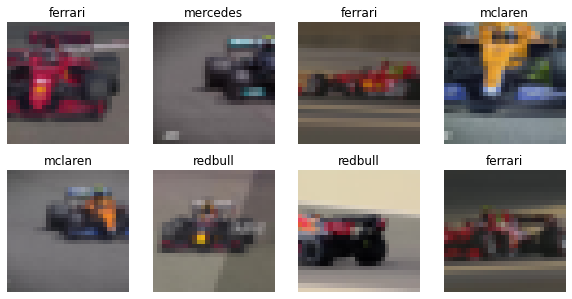

In [66]:
data.show_batch(figsize=(10,5) )

Modelin Oluşumu ve Eğitimi

In [96]:
model = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(4, 8, kernel_size=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(8, 16, kernel_size=(2,2)),
    nn.ReLU(),
    nn.Flatten(),

    nn.Linear(400,200),
    nn.Linear(200,50),
    nn.ReLU(),
    nn.Linear(50,25),
    nn.ReLU(),
    nn.Linear(25,8),
    nn.Linear(8,4),
    nn.Softmax()

)

In [97]:
model

Sequential(
  (0): Conv2d(3, 4, kernel_size=(2, 2), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=400, out_features=200, bias=True)
  (10): Linear(in_features=200, out_features=50, bias=True)
  (11): ReLU()
  (12): Linear(in_features=50, out_features=25, bias=True)
  (13): ReLU()
  (14): Linear(in_features=25, out_features=8, bias=True)
  (15): Linear(in_features=8, out_features=4, bias=True)
  (16): Softmax(dim=None)
)

In [98]:
learn = Learner(data, model, loss_func=fastai.losses.CrossEntropyLossFlat(), metrics=[accuracy, error_rate])

In [100]:
learn.summary()

Sequential (Input shape: 8 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 4 x 27 x 27     
Conv2d                                    52         True      
ReLU                                                           
____________________________________________________________________________
                     8 x 4 x 13 x 13     
MaxPool2d                                                      
____________________________________________________________________________
                     8 x 8 x 12 x 12     
Conv2d                                    136        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 8 x 6 x 6       
MaxPool2d                                                      
____________________________________________________________________________
                     8 x 16 x 5 x 

Eğitim

 - 1. İlk Eğitim 

###### Modeli hızlı ve yüksek doğruluklu eğitmek için büyük ve döngüsel öğrenme oranları kullanır.

In [101]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.387086,1.386482,0.250000,0.750000,00:25
1,1.386562,1.386392,0.250000,0.750000,00:27
2,1.386357,1.386312,0.250000,0.750000,00:23
3,1.386461,1.386218,0.282143,0.717857,00:21
4,1.386912,1.385931,0.250000,0.750000,00:22
5,1.386048,1.381576,0.292857,0.707143,00:19
6,1.377540,1.340426,0.400000,0.600000,00:20
7,1.357845,1.329552,0.353571,0.646429,00:21
8,1.336949,1.301313,0.396429,0.603571,00:19
9,1.322822,1.340050,0.367857,0.632143,00:20


- 2. Normal Eğitim

In [102]:
learn.fit(20, 0.001)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.297948,1.284538,0.410714,0.589286,00:24
1,1.287658,1.273492,0.403571,0.596429,00:24
2,1.284392,1.283001,0.414286,0.585714,00:23
3,1.278948,1.265808,0.410714,0.589286,00:24
4,1.278236,1.261634,0.428571,0.571429,00:21
5,1.267693,1.245413,0.453571,0.546429,00:21
6,1.263103,1.256613,0.414286,0.585714,00:22
7,1.259157,1.229170,0.464286,0.535714,00:27
8,1.245053,1.210700,0.489286,0.510714,00:28
9,1.230666,1.192956,0.571429,0.428571,00:21


- 3. Fine Tune

In [104]:
learn.fine_tune(20,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.924389,0.877752,0.875000,0.125000,00:23
1,0.939154,0.937883,0.810714,0.189286,00:22
2,0.985274,0.934580,0.807143,0.192857,00:25
3,1.006534,0.907991,0.828571,0.171429,00:30


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.920168,0.897594,0.850000,0.150000,00:30
1,0.926888,0.892103,0.860714,0.139286,00:20
2,0.916190,0.892434,0.857143,0.142857,00:21
3,0.919986,0.902150,0.850000,0.150000,00:25
4,0.940332,0.886118,0.857143,0.142857,00:29
5,0.959929,0.912060,0.828571,0.171429,00:28
6,0.950992,0.941882,0.803571,0.196429,00:34
7,0.945811,0.907479,0.832143,0.167857,00:38
8,0.930747,0.908205,0.832143,0.167857,00:22
9,0.955056,0.873814,0.867857,0.132143,00:43


Test